In [20]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import glob
import os

# Dataset

## Visualization utils

In [17]:
def plot_samples(dataset, split, seed):
    np.random.seed(seed)
    print(f"Plot Samples (seed = {seed}, {split} split)")

    plt.figure(figsize=(10, 5))
    found_samples = {i: False for i in range(8)}
    
    while not all(found_samples.values()):
        idx = np.random.randint(0, len(dataset))
        image , label = dataset[idx]
        if found_samples[label]:
            continue
        # Plot the image
        plt.subplot(2, 4, label + 1)
        plt.imshow(image.squeeze().permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
        found_samples[label] = True
    plt.tight_layout()
    plt.show()
    
def plot_label_distribution_histogram(dataset, split):
    labels = [label for _, label in dataset]

    counts = [labels.count(i) for i in range(8)]

    fig, ax = plt.subplots()
    ax.bar(range(8), counts)

    for i in range(8):
        ax.text(i, counts[i], f"{100*(counts[i]/sum(counts)):.1f} %", ha="center", va="bottom")

    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_xticks(range(8))
    ax.set_xticklabels(range(8), ha="center")
    ax.set_title(f"Histogram of labels distribution for {split} split")
    plt.tight_layout()
    plt.show()

## Load and Prepare datasets

In [22]:
TRAIN_DATA_PATH = "dataset/TRAIN"
TUNE_DATA_PATH = "dataset/TUNE"
TRAIN_SPLIT_OF_ALL = 0.8

In [36]:
scale = torchvision.transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=20), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    scale,
])
tune_transforms = transforms.Compose([
    transforms.ToTensor(),
    scale,
])

train_valid_dataset = ImageFolder(
    root=TRAIN_DATA_PATH,
    transform=train_transforms,
)
tune_dataset = ImageFolder(
    root=TUNE_DATA_PATH,
    transform=tune_transforms,
)

## Explore datasets

Plot Samples (seed = 21, train+valid split)


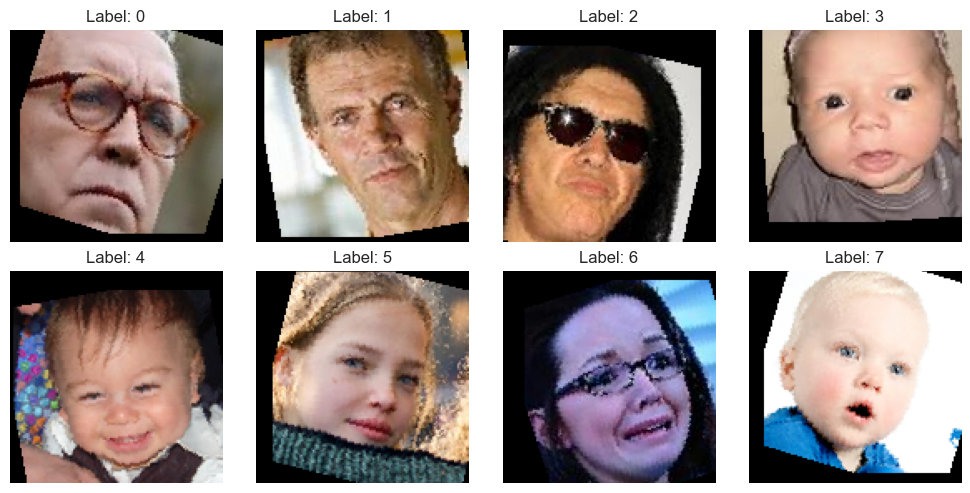

In [37]:
plot_samples(
    dataset=train_valid_dataset, 
    split="train+valid", 
    seed=21,
)

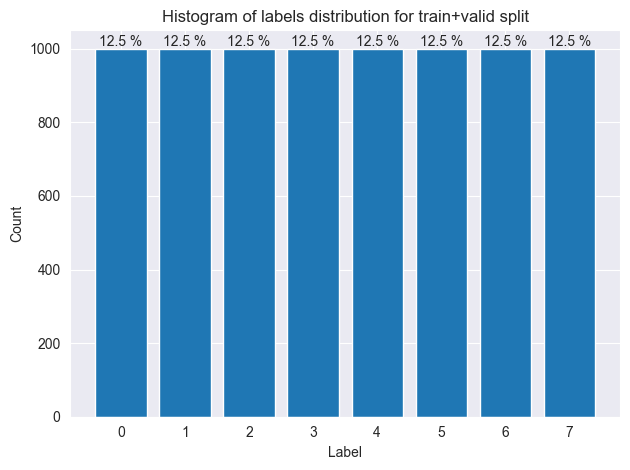

In [34]:
plot_label_distribution_histogram(
    dataset=train_valid_dataset, 
    split="train+valid",
)

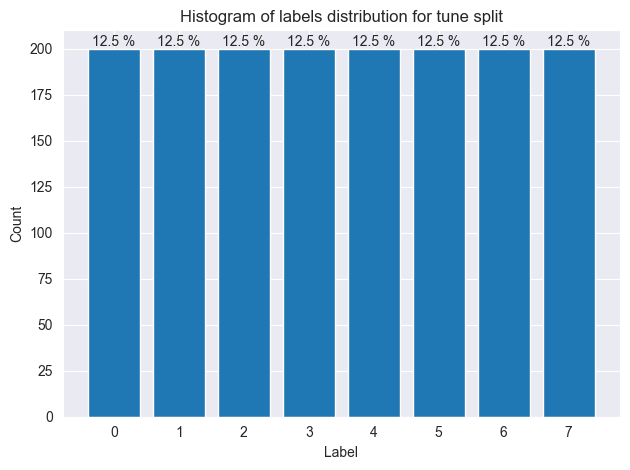

In [35]:
plot_label_distribution_histogram(
    dataset=tune_dataset, 
    split="tune",
)

## Split train-validation

In [23]:
labels = [sample[1] for sample in train_valid_dataset]

train_dataset, valid_dataset = train_test_split(
    train_valid_dataset,
    train_size=TRAIN_SPLIT_OF_ALL,
    stratify=labels,
    random_state=42
)

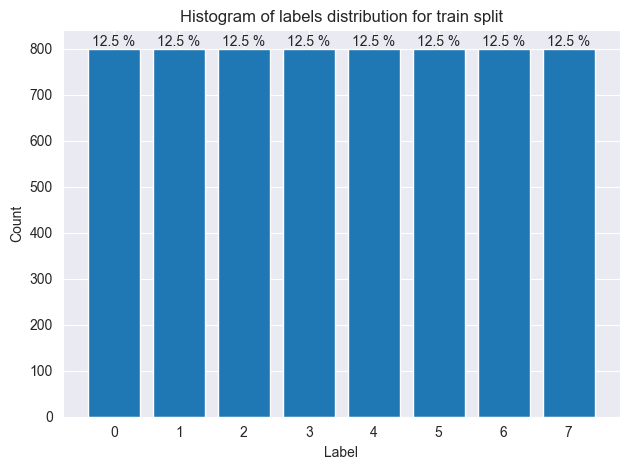

In [24]:
plot_label_distribution_histogram(
    dataset=train_dataset, 
    split="train",
)

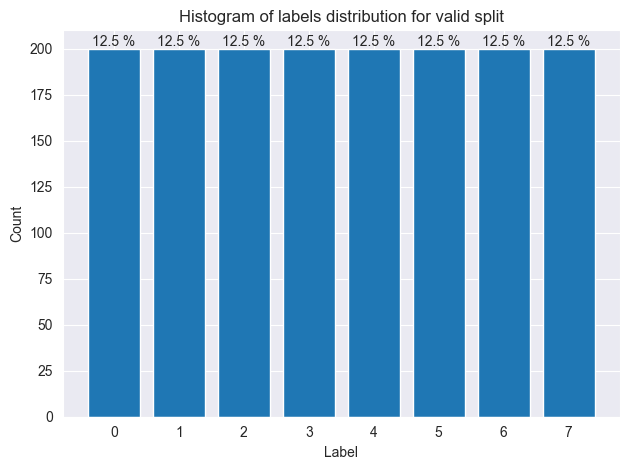

In [25]:
plot_label_distribution_histogram(
    dataset=valid_dataset, 
    split="valid",
)

## Create data loaders

In [ ]:
train_loader = DataLoader(train_dataset)
valid_loader = DataLoader(valid_dataset)
Tune_loader = DataLoader(tune_dataset)

# Models

## Costume conv block

In [ ]:
class CostumeConv(nn.Module):
    def __init__(self, in_chan, out_chan, kernel=(3,3), stride=(1,1), padding=(1,1)):
        super(CostumeConv, self).__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=kernel, padding=padding, stride=stride),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.block(x)
        

## VGG model

In [ ]:
class VGG(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(VGG, self).__init__()
        
        self.network = nn.Sequential(
            
        )
        